In [ ]:
# =============================================
#  ML LAB WEEK 13 - CLUSTERING (PES2UG23CS193)
# =============================================

# Setup
# ---------------------------------------------
# Install if missing:
# !pip install pandas numpy matplotlib seaborn scikit-learn

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.impute import SimpleImputer

plt.rcParams['figure.figsize'] = (8,6)
sns.set(style="whitegrid")


In [ ]:
# Load CSV (use correct path)
df = pd.read_csv('/content/bank-full.csv', sep=';')

print("Shape:", df.shape)
df.head()

Shape: (45211, 17)


,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


In [ ]:
df.info()
print("\nMissing values per column:\n", df.isnull().sum())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        45211 non-null  int64 
 1   job        45211 non-null  object
 2   marital    45211 non-null  object
 3   education  45211 non-null  object
 4   default    45211 non-null  object
 5   balance    45211 non-null  int64 
 6   housing    45211 non-null  object
 7   loan       45211 non-null  object
 8   contact    45211 non-null  object
 9   day        45211 non-null  int64 
 10  month      45211 non-null  object
 11  duration   45211 non-null  int64 
 12  campaign   45211 non-null  int64 
 13  pdays      45211 non-null  int64 
 14  previous   45211 non-null  int64 
 15  poutcome   45211 non-null  object
 16  y          45211 non-null  object
dtypes: int64(7), object(10)
memory usage: 5.9+ MB

Missing values per column:
 age          0
job          0
marital      0
education    0
default   

In [ ]:
df.info()
print("\nMissing values per column:\n", df.isnull().sum())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        45211 non-null  int64 
 1   job        45211 non-null  object
 2   marital    45211 non-null  object
 3   education  45211 non-null  object
 4   default    45211 non-null  object
 5   balance    45211 non-null  int64 
 6   housing    45211 non-null  object
 7   loan       45211 non-null  object
 8   contact    45211 non-null  object
 9   day        45211 non-null  int64 
 10  month      45211 non-null  object
 11  duration   45211 non-null  int64 
 12  campaign   45211 non-null  int64 
 13  pdays      45211 non-null  int64 
 14  previous   45211 non-null  int64 
 15  poutcome   45211 non-null  object
 16  y          45211 non-null  object
dtypes: int64(7), object(10)
memory usage: 5.9+ MB

Missing values per column:
 age          0
job          0
marital      0
education    0
default   

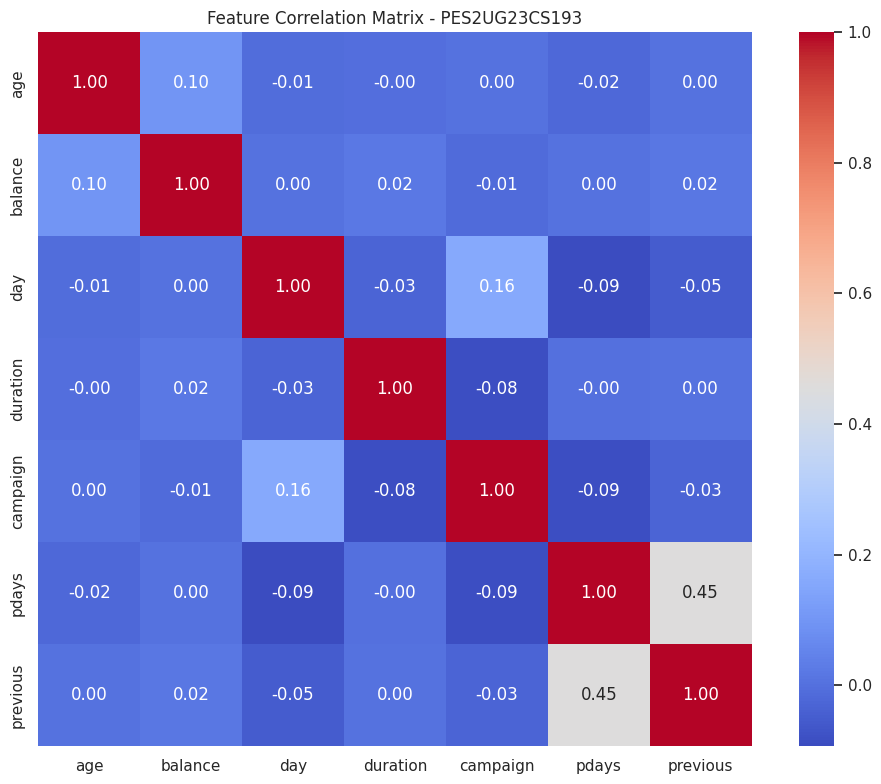

In [ ]:
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
corr = df[num_cols].corr()

plt.figure(figsize=(10,8))
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', square=True)
plt.title("Feature Correlation Matrix - PES2UG23CS193")
plt.tight_layout()
plt.savefig('corr_matrix.png', dpi=200)
plt.show()


In [ ]:
# Drop target 'y' if present
df_cluster = df.drop(columns=['y']) if 'y' in df.columns else df.copy()

cat_cols = df_cluster.select_dtypes(include=['object']).columns.tolist()
num_cols = df_cluster.select_dtypes(include=[np.number]).columns.tolist()

num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer([
    ('num', num_pipeline, num_cols),
    ('cat', cat_pipeline, cat_cols)
])

X_processed = preprocessor.fit_transform(df_cluster)

# Get feature names
ohe = preprocessor.named_transformers_['cat'].named_steps['onehot']
cat_feature_names = ohe.get_feature_names_out(cat_cols)
feature_names = num_cols + list(cat_feature_names)

X = pd.DataFrame(X_processed, columns=feature_names)
print("Processed shape:", X.shape)

Processed shape: (45211, 51)


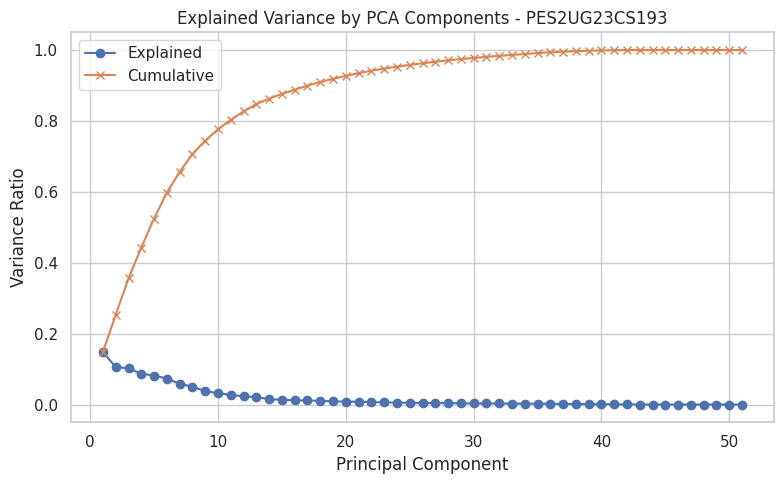

Variance captured by PC1+PC2: 25.36%


In [ ]:
pca = PCA()
X_pca = pca.fit_transform(X)
explained = pca.explained_variance_ratio_
cum_var = explained.cumsum()

plt.figure(figsize=(8,5))
plt.plot(range(1,len(explained)+1), explained, marker='o', label='Explained')
plt.plot(range(1,len(cum_var)+1), cum_var, marker='x', label='Cumulative')
plt.xlabel("Principal Component")
plt.ylabel("Variance Ratio")
plt.title("Explained Variance by PCA Components - PES2UG23CS193")
plt.legend()
plt.tight_layout()
plt.savefig('pca_explained_variance.png', dpi=200)
plt.show()

first_two = explained[0]+explained[1]
print(f"Variance captured by PC1+PC2: {first_two*100:.2f}%")


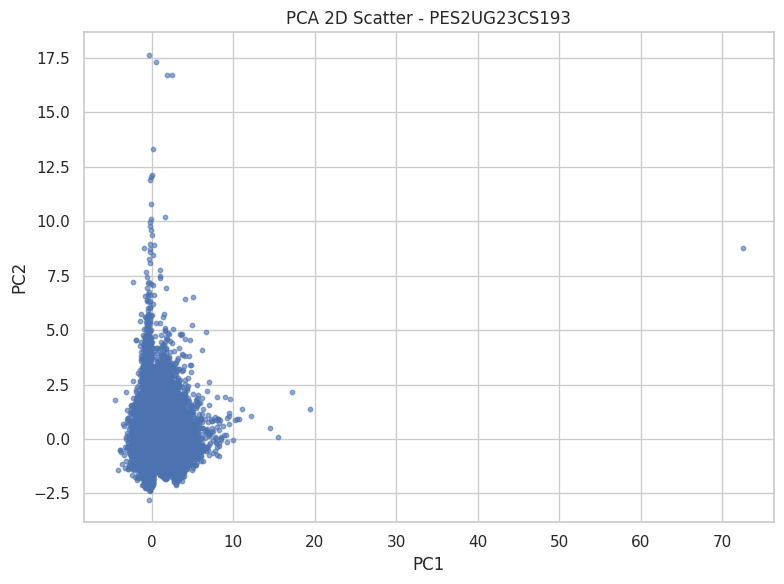

In [ ]:
pca_2 = PCA(n_components=2)
X_pca2 = pca_2.fit_transform(X)

plt.figure(figsize=(8,6))
plt.scatter(X_pca2[:,0], X_pca2[:,1], s=10, alpha=0.6)
plt.xlabel('PC1'); plt.ylabel('PC2')
plt.title("PCA 2D Scatter - PES2UG23CS193")
plt.tight_layout()
plt.savefig('pca_scatter.png', dpi=200)
plt.show()


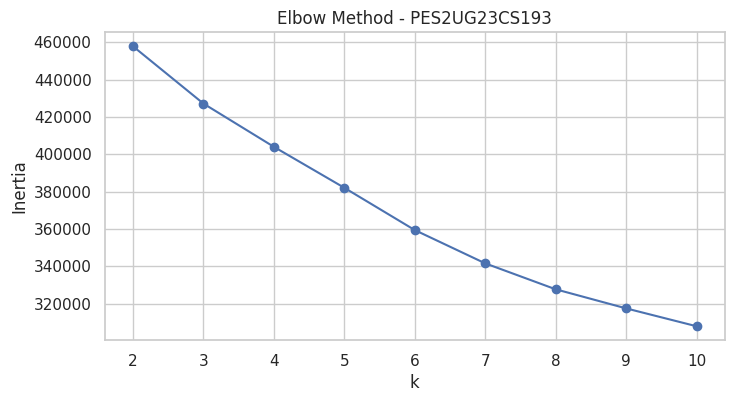

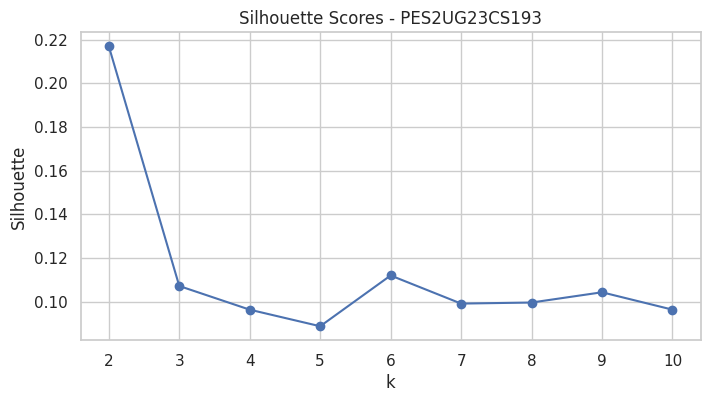

[(2, 457921.47659526067, np.float64(0.21691641704345488)), (3, 427210.6661319996, np.float64(0.10725383703942311)), (4, 404035.6890215664, np.float64(0.0964271447276041)), (5, 382074.20918519446, np.float64(0.08884515709064303)), (6, 359407.22211501823, np.float64(0.11207135757882926)), (7, 341567.6072283414, np.float64(0.09921085386379017)), (8, 327663.1559882497, np.float64(0.09969102505688654)), (9, 317430.9801994471, np.float64(0.1043829086799446)), (10, 307853.92125138966, np.float64(0.09643980946785352))]


In [ ]:
range_n = range(2,11)
inertias, sil_scores = [], []

for k in range_n:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X)
    inertias.append(kmeans.inertia_)
    sil_scores.append(silhouette_score(X, labels))

plt.figure(figsize=(8,4))
plt.plot(range_n, inertias, marker='o')
plt.title("Elbow Method - PES2UG23CS193")
plt.xlabel("k"); plt.ylabel("Inertia")
plt.savefig('inertia_plot.png', dpi=200)
plt.show()

plt.figure(figsize=(8,4))
plt.plot(range_n, sil_scores, marker='o')
plt.title("Silhouette Scores - PES2UG23CS193")
plt.xlabel("k"); plt.ylabel("Silhouette")
plt.savefig('silhouette_scores.png', dpi=200)
plt.show()

print(list(zip(range_n, inertias, sil_scores)))


In [ ]:
k_opt = 3   # choose after inspecting above plots
kmeans_final = KMeans(n_clusters=k_opt, random_state=42, n_init=20)
labels = kmeans_final.fit_predict(X)

print("Cluster sizes:\n", pd.Series(labels).value_counts().sort_index())
print("Silhouette score:", silhouette_score(X, labels))


Cluster sizes:
 0    15266
1     7066
2    22879
Name: count, dtype: int64
Silhouette score: 0.10742669136804282


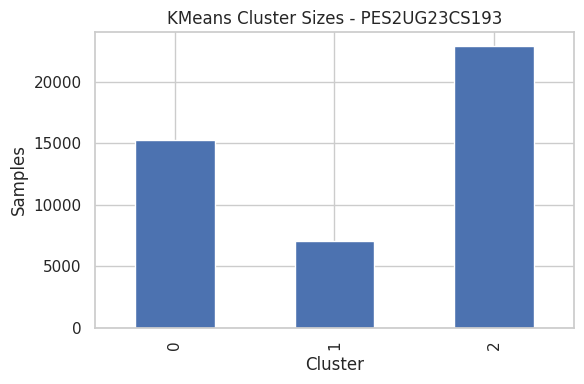

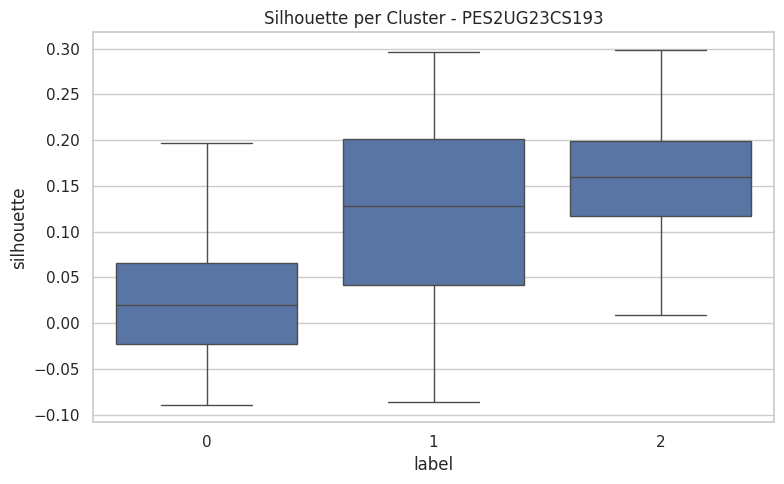

In [ ]:
# Cluster sizes bar chart
plt.figure(figsize=(6,4))
pd.Series(labels).value_counts().sort_index().plot(kind='bar')
plt.xlabel("Cluster"); plt.ylabel("Samples")
plt.title("KMeans Cluster Sizes - PES2UG23CS193")
plt.tight_layout()
plt.savefig('kmeans_cluster_sizes.png', dpi=200)
plt.show()

# Silhouette per cluster
sil_samples = silhouette_samples(X, labels)
df_sil = pd.DataFrame({'label': labels, 'silhouette': sil_samples})
plt.figure(figsize=(8,5))
sns.boxplot(x='label', y='silhouette', data=df_sil)
plt.title("Silhouette per Cluster - PES2UG23CS193")
plt.tight_layout()
plt.savefig('kmeans_silhouette_boxplot.png', dpi=200)
plt.show()


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


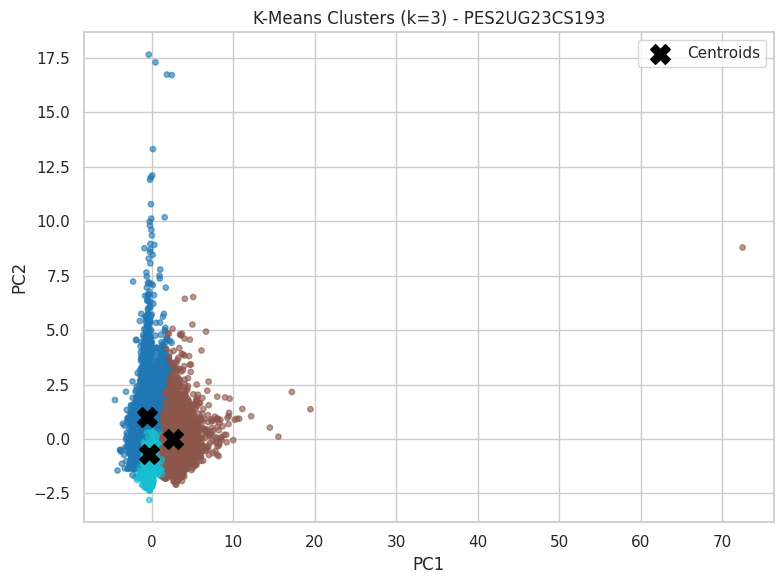

In [ ]:
centroids_pca = pca_2.transform(kmeans_final.cluster_centers_)

plt.figure(figsize=(8,6))
plt.scatter(X_pca2[:,0], X_pca2[:,1], c=labels, cmap='tab10', s=15, alpha=0.6)
plt.scatter(centroids_pca[:,0], centroids_pca[:,1], c='black', marker='X', s=200, label='Centroids')
plt.title(f"K-Means Clusters (k={k_opt}) - PES2UG23CS193")
plt.xlabel('PC1'); plt.ylabel('PC2')
plt.legend()
plt.tight_layout()
plt.savefig('kmeans_pca_clusters.png', dpi=200)
plt.show()


In [ ]:
def bisecting_kmeans(X, k, random_state=42):
    clusters = {0: np.arange(X.shape[0])}
    next_id = 1

    def sse(idx):
        subset = X[idx]
        return ((subset - subset.mean(axis=0))**2).sum()

    while len(clusters) < k:
        to_split = max(clusters, key=lambda c: sse(clusters[c]))
        idx = clusters.pop(to_split)
        km = KMeans(n_clusters=2, random_state=random_state, n_init=10)
        labels_sub = km.fit_predict(X[idx])
        clusters[to_split] = idx[labels_sub==0]
        clusters[next_id] = idx[labels_sub==1]
        next_id += 1

    labels_out = np.zeros(X.shape[0], dtype=int)
    for cid, idx in clusters.items():
        labels_out[idx] = cid
    mapping = {old:new for new, old in enumerate(sorted(clusters.keys()))}
    for old,new in mapping.items():
        labels_out[labels_out==old] = new
    return labels_out

labels_bisect = bisecting_kmeans(X.values, k_opt)
print("Bisecting sizes:\n", pd.Series(labels_bisect).value_counts().sort_index())
print("Bisecting silhouette:", silhouette_score(X, labels_bisect))


Bisecting sizes:
 0    18461
1     7696
2    19054
Name: count, dtype: int64
Bisecting silhouette: 0.09236193868961763


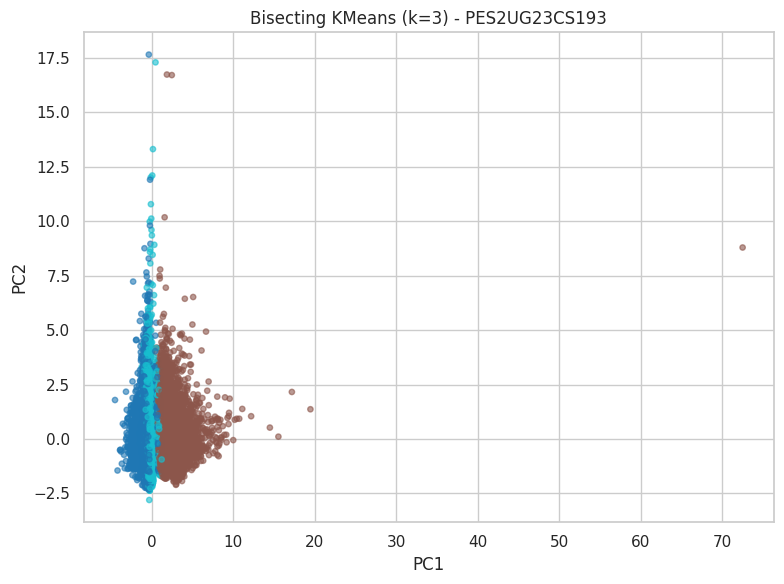

In [ ]:
plt.figure(figsize=(8,6))
plt.scatter(X_pca2[:,0], X_pca2[:,1], c=labels_bisect, cmap='tab10', s=15, alpha=0.6)
plt.xlabel('PC1'); plt.ylabel('PC2')
plt.title(f"Bisecting KMeans (k={k_opt}) - PES2UG23CS193")
plt.tight_layout()
plt.savefig('bisecting_pca_clusters.png', dpi=200)
plt.show()


In [ ]:
print("KMeans silhouette:", silhouette_score(X, labels))
print("Bisecting silhouette:", silhouette_score(X, labels_bisect))
print("\nKMeans sizes:\n", pd.Series(labels).value_counts().sort_index())
print("\nBisecting sizes:\n", pd.Series(labels_bisect).value_counts().sort_index())


KMeans silhouette: 0.10742669136804282
Bisecting silhouette: 0.09236193868961763

KMeans sizes:
 0    15266
1     7066
2    22879
Name: count, dtype: int64

Bisecting sizes:
 0    18461
1     7696
2    19054
Name: count, dtype: int64
